### 1. Imports

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import json
import jsbeautifier
from datetime import datetime

In [2]:
# Import classes
from rl_environment import Environment

### 2. Parameter Selection

#### Parameters for Simulation

In [3]:
# Main Parameters
number_of_regional_warehouses = 3
max_inventory_amount_regional_warehouses = 50
max_inventory_amount_central_warehouse = 100
customer_demand_per_step = [2,4,3]  # List needs one entry per regional warehouse 
simulation_length = 50
lead_time = 2

# Shipments
shipment_amount = [10]  # Regarding regional warehouses
shipment_var_cost_per_unit = 0.01 # Acts as Reward penalty
shipment_fixed_cost = .15  # Acts as Reward penalty

# Manufacturer addition
with_manufacturer = True # Simulate Manufacturer and CW inventory
manufacturer_prod_capacity_per_step = 15
manufacturer_inventory_limit = 200
cw_shipment_amount = 25  # Regarding central warehouse

# Fluctuations & Priorities
demand_fluctuation = 1
lead_time_fluctuation = 0
customer_priorities = [1, 1, 1] # List needs one entry per RW customer

# Advanced Demand Simulation
use_advanced_demand_simulation = False # Simulated demand curves & integrated demand forcasting in observation space
demand_curve_length_multiplier = 1 # Standard = 1
forecast_range = 10 # Determines the number of Steps the agent recieves as forecast values
forecast_deviation_factor = 1 # Standard = 1, Can be increased or decrease to control the accuracy of the forecasts

# Reward prioritization
rw_inventory_holding_cost_multiplier = 1 # Standard = 1; Can be lowered; Not higher that 1
rw_inventory_holding_cost_drop_off = .5 # Standard = 1; Lowering usefull, if large demand & shipping amount
cw_inventory_holding_cost_multiplier = .5 # Standard = 1; Can be lowered; Not higher that 1
cw_inventory_holding_cost_drop_off  = .25 # Standard = 1; Lowering usefull, if large demand & shipping amount

#### Parameters for Agent Training

In [4]:
algorithm = "PPO"  # "PPO", "A2C" or "DQN"
training_steps = 200000
new_demand_curve_on_reset = True  # If anvanced demand sim is enabled, will create a new demand curve every reset

print("-> Equals to " + str(int(training_steps/simulation_length)) + " training episodes")

-> Equals to 4000 training episodes


###### Parameters for Logging File

In [5]:
create_logfile = True
logfile_location = "./logfiles" # Can be partial or full path. Empty string for current directory

### 3. Environment Creation

###### Determine if chosen algorithm needs discrete action space

In [6]:
algorithms_that_need_single_action_value = ["DQN"]

if algorithm.upper() in algorithms_that_need_single_action_value:
    use_single_value_action_space = True
else:
    use_single_value_action_space = False

#### Creating Environment

In [7]:
env = Environment(number_of_regional_wh = number_of_regional_warehouses, 
                  rw_inventory_limit = max_inventory_amount_regional_warehouses, 
                  cw_inventory_limit = max_inventory_amount_central_warehouse,
                  demand = customer_demand_per_step,
                  sim_length = simulation_length,
                  lead_time = lead_time,
                  shipment_amount = shipment_amount,
                  manufacturer = with_manufacturer,
                  cw_shipment_amount = cw_shipment_amount,
                  mf_prod_capacity = manufacturer_prod_capacity_per_step,
                  shipment_var_cost_per_unit = shipment_var_cost_per_unit,
                  shipment_fixed_cost = shipment_fixed_cost,
                  inventory_holding_cost_multiplier = rw_inventory_holding_cost_multiplier,
                  cw_inventory_holding_cost_multiplier = cw_inventory_holding_cost_multiplier,
                  demand_fluctuation = demand_fluctuation,
                  lead_time_fluctuation = lead_time_fluctuation,
                  use_single_value_action_space = use_single_value_action_space,
                  customer_priorities = customer_priorities,
                  rw_inventory_holding_cost_drop_off = rw_inventory_holding_cost_drop_off,
                  cw_inventory_holding_cost_drop_off = cw_inventory_holding_cost_drop_off,
                  use_advanced_demand_simulation = use_advanced_demand_simulation,
                  demand_curve_length_multiplier = demand_curve_length_multiplier,
                  manufacturer_inventory_limit = manufacturer_inventory_limit,
                  new_demand_curve_on_reset = new_demand_curve_on_reset,
                  forecast_range = forecast_range,
                  forecast_deviation_factor = forecast_deviation_factor
                 )

env.print_environment_information()

Simulation created with the following parameters:
________________________________________________________________________________
Simulation | Round 1
-------------------
-> Active shipments:
No active shipments

-> Warehouses:
central_warehouse ; Inventory: 33
regional_warehouse_1 ; ID: 1 ; Inventory: 16 ; Demand: 2 ; Priority: 1.0 ; Lost sales: 0
regional_warehouse_2 ; ID: 2 ; Inventory: 16 ; Demand: 4 ; Priority: 1.0 ; Lost sales: 0
regional_warehouse_3 ; ID: 3 ; Inventory: 16 ; Demand: 3 ; Priority: 1.0 ; Lost sales: 0

-> Production plant:
manufacturer ; Production per step: 15 ; Inventory: 66
________________________________________________________________________________
Environment Information
-----------------------
-> Gym spaces:
Observation space: Dict(cw_amount_in_transit:Discrete(51), cw_inventory:Discrete(101), cw_next_arrival:Discrete(3), cw_shipment:Discrete(2), next_arrival:MultiDiscrete([3 3 3]), rw_amount_in_transit:MultiDiscrete([21 21 21]), rw_inventories:MultiDis

###### Initiate Logfile

In [8]:
if create_logfile:
    parameter_dict = {"number_of_regional_warehouses" : number_of_regional_warehouses,"rw_inventory_limit" :
                      max_inventory_amount_regional_warehouses, "cw_inventory_limit" : max_inventory_amount_central_warehouse,
                      "demand" : customer_demand_per_step, "sim_length" : simulation_length, "lead_time" : lead_time,
                      "shipment_amount" : shipment_amount, "manufacturer" : with_manufacturer, "cw_shipment_amount" : 
                      cw_shipment_amount, "mf_prod_capacity" : manufacturer_prod_capacity_per_step, "customer_priorities" : 
                      customer_priorities, "shipment_var_cost_per_unit" : shipment_var_cost_per_unit, "shipment_fixed_cost" : 
                      shipment_fixed_cost, "inventory_holding_cost_multiplier" : rw_inventory_holding_cost_multiplier,
                      "cw_inventory_holding_cost_multiplier" : cw_inventory_holding_cost_multiplier,"demand_fluctuation" : 
                      demand_fluctuation, "lead_time_fluctuation" : lead_time_fluctuation, "use_single_value_action_space" : 
                      use_single_value_action_space, "rw_inventory_cost_drop_off" : rw_inventory_holding_cost_drop_off,
                      "cw_inventory_cost_drop_off" : cw_inventory_holding_cost_drop_off, "use_advanced_demand_simulation" :
                      use_advanced_demand_simulation, "demand_curve_length_multiplier": demand_curve_length_multiplier,
                      "manufacturer_inventory_limit": manufacturer_inventory_limit, "forecast_range": forecast_range, 
                      "forecast_deviation_factor": forecast_deviation_factor
                     }
    
    algorithm_dict = {"rl_model": algorithm, "num_of_training_steps": training_steps,
                      "training_episodes": int(training_steps/simulation_length)}
    json_dict = {"simulation_parameters":parameter_dict, "rl_model_training": algorithm_dict}

### 4. RL Model Training

###### Model Selection
PPO (Proximal Policy Optimization)
https://openai.com/blog/openai-baselines-ppo/

A2C
https://openai.com/blog/baselines-acktr-a2c/

DQN
https://openai.com/blog/openai-baselines-dqn/

In [9]:
# Choose algorithm based on user decision
if algorithm.upper() == "PPO":
    trained_model = PPO("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "A2C":
    trained_model = A2C("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "DQN":
    trained_model = DQN("MultiInputPolicy", env, verbose=1)
else:
    print("Model not found")
    exit()

# Start model training
trained_model.learn(total_timesteps=training_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -1.36    |
| time/              |          |
|    fps             | 407      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -1.06       |
| time/                   |             |
|    fps                  | 331         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010951567 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 1.9         |
| time/                   |             |
|    fps                  | 267         |
|    iterations           | 11          |
|    time_elapsed         | 84          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.024440331 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.26       |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00839    |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0523     |
|    value_loss           | 0.157       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 4.09        |
| time/                   |             |
|    fps                  | 270         |
|    iterations           | 21          |
|    time_elapsed         | 159         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.021667615 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.244       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.295       |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0395     |
|    value_loss           | 0.667       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 5.17        |
| time/                   |             |
|    fps                  | 264         |
|    iterations           | 31          |
|    time_elapsed         | 239         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.023872495 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.0692      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.316       |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 1.03        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 5.64        |
| time/                   |             |
|    fps                  | 261         |
|    iterations           | 41          |
|    time_elapsed         | 321         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.023748558 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.0821      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.408       |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0323     |
|    value_loss           | 1.07        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 6.14        |
| time/                   |             |
|    fps                  | 254         |
|    iterations           | 51          |
|    time_elapsed         | 411         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.024593197 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.0984      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.633       |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0305     |
|    value_loss           | 1.44        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 6.42        |
| time/                   |             |
|    fps                  | 253         |
|    iterations           | 61          |
|    time_elapsed         | 491         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.024378136 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.957      |
|    explained_variance   | 0.0838      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.479       |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.0282     |
|    value_loss           | 1.52        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 6.88        |
| time/                   |             |
|    fps                  | 254         |
|    iterations           | 71          |
|    time_elapsed         | 572         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.024137734 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.827      |
|    explained_variance   | 0.115       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.738       |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.027      |
|    value_loss           | 1.76        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50    

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50         |
|    ep_rew_mean          | 7.21       |
| time/                   |            |
|    fps                  | 256        |
|    iterations           | 81         |
|    time_elapsed         | 647        |
|    total_timesteps      | 165888     |
| train/                  |            |
|    approx_kl            | 0.02494708 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.742     |
|    explained_variance   | 0.121      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.979      |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.027     |
|    value_loss           | 1.84       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 7.42        |
| time/                   |             |
|    fps                  | 254         |
|    iterations           | 91          |
|    time_elapsed         | 732         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.020678319 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.696      |
|    explained_variance   | 0.151       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.05        |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.0236     |
|    value_loss           | 1.78        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50      

###### Learning Curve

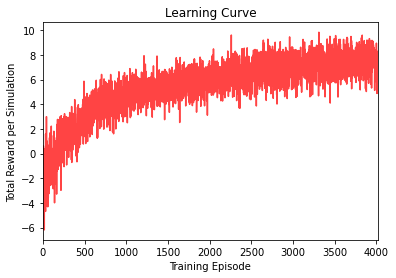

In [10]:
# Plot learning curve
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(env.total_reward, color="#FF4444")
plt.title("Learning Curve")
plt.xlim(0, len(env.total_reward))
plt.ylabel("Total Reward per Simulation")
plt.xlabel("Training Episode")
plt.show()

if create_logfile:
    rounded_rewards = []
    for reward in env.total_reward:
        rounded_rewards.append(round(reward, 2))
    json_dict["rl_model_training"]["training_rewards"] = rounded_rewards

# Print used data if True
if False:
    print("Total Rewards:", env.total_reward)

### 5. Run Simulation

In [11]:
# Convert actions for graphs
def convert_to_marker_pos(action):
    return_list = []
    i = 0
    for entry in action:
        if entry != 0:
            return_list.append(i)
        i += 1
    return return_list


# Graph data
cw_inventory_level, cw_actions = [], []
inventory_levels, actions = {}, {}
manufacturer_inventory = []

for rw_id in env.simulation.get_regional_warehouses():
    inventory_levels[rw_id] = []
    actions[rw_id] = []

In [12]:
# Reset environment for simulation
state = env.reset()
done = False

# Run simulation with model
while not done:
    action, _states = trained_model.predict(state) 
    state, reward, done, info = env.step(action)
    
    # For Graph
    i = 1
    for inv in info["RW Invs:"]:
        inventory_levels[i].append(inv)
        i += 1

    i = 1
    for act in info["Action:"][0:len(env.simulation.get_regional_warehouses())]:
        actions[i].append(act)
        i += 1
    
    try:
        cw_inventory_level.append(info["CW Inv:"])
        cw_actions.append(info["Action:"][-1])
        manufacturer_inventory.append(info["Manufacturer:"])
    except:
        pass
    
    # print(env.simulation.print_state())
    for i in info:
        print(i, info[i], end=" | ")
    print()
    
print("\n", env.evaluation_parameters())

Round: 1 | RW Invs: [14, 11, 13] | Shipments [0, 0, 0] | Action: [0, 0, 0, 0] | Reward: 0.12 | CW Inv: 33 | Manufacturer: 81 | 
Round: 2 | RW Invs: [12, 6, 10] | Shipments [0, 1, 0] | Action: [0, 1, 0, 0] | Reward: 0.1 | CW Inv: 23 | Manufacturer: 96 | 
Round: 3 | RW Invs: [9, 3, 6] | Shipments [0, 1, 1] | Action: [0, 0, 1, 1] | Reward: 0.17 | CW Inv: 13 | Manufacturer: 86 | 
Round: 4 | RW Invs: [8, 8, 4] | Shipments [0, 0, 1] | Action: [0, 0, 0, 0] | Reward: 0.21 | CW Inv: 13 | Manufacturer: 101 | 
Round: 5 | RW Invs: [5, 4, 11] | Shipments [0, 1, 0] | Action: [0, 1, 0, 0] | Reward: 0.15 | CW Inv: 28 | Manufacturer: 116 | 
Round: 6 | RW Invs: [3, 1, 9] | Shipments [1, 1, 0] | Action: [1, 0, 0, 1] | Reward: 0.27 | CW Inv: 18 | Manufacturer: 106 | 
Round: 7 | RW Invs: [0, 6, 5] | Shipments [1, 1, 0] | Action: [0, 1, 1, 0] | Reward: 0.3 | CW Inv: 8 | Manufacturer: 121 | 
Round: 8 | RW Invs: [8, 3, 1] | Shipments [1, 1, 1] | Action: [1, 0, 1, 1] | Reward: 0.22 | CW Inv: 13 | Manufacturer:

###### Inventory level graphs

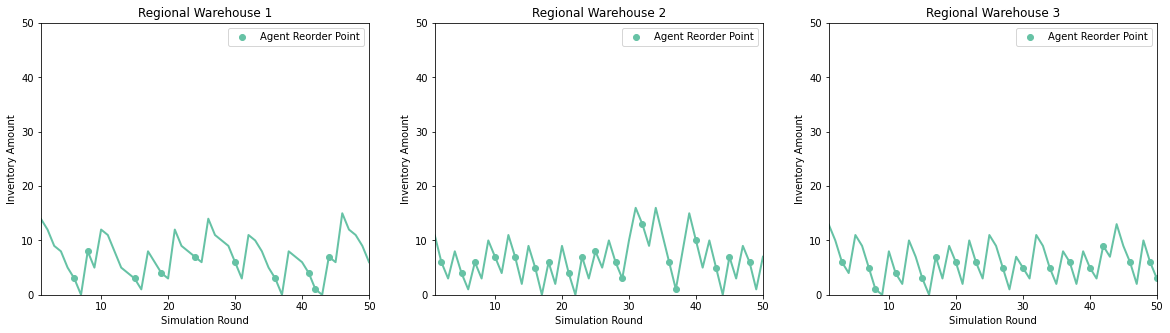

In [13]:
# Plots inventories of regional warehouses

reorder_marker = mlines.Line2D([],[], color='#66C2A5', marker='o', linestyle='None', label="Agent Reorder Point")
plt.rcParams["figure.figsize"] = (20, 5)

for rw_id in inventory_levels:
    plt.subplot(1, number_of_regional_warehouses, rw_id)
    plt.plot([0] + inventory_levels[rw_id], "-bo", markevery=convert_to_marker_pos([0] + actions[rw_id]), color="#66C2A5", linewidth=2)
    plt.legend(handles=[reorder_marker])
    plt.title("Regional Warehouse " + str(rw_id))
    plt.ylim(0, max_inventory_amount_regional_warehouses)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Simulation Round")
    
    # Print used data if True
    if False:
        print("RW", rw_id, "data:")
        print("Inventory:", inventory_levels[rw_id])
        print("Actions:", actions[rw_id])
        print("_"*100)

plt.show()

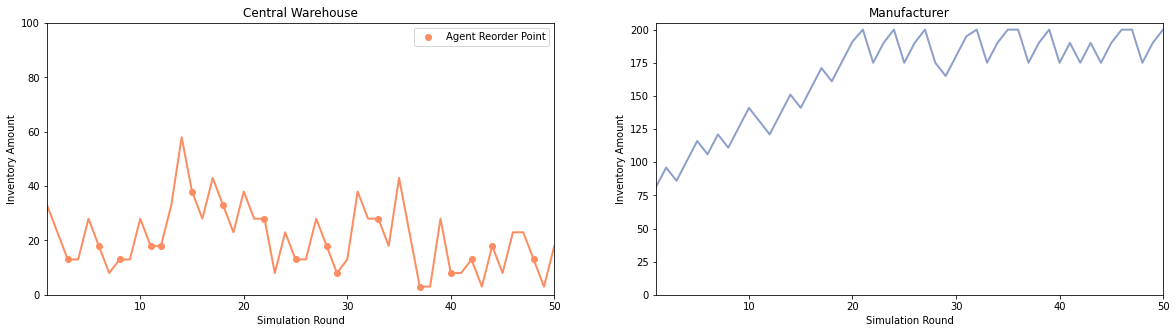

In [14]:
# Plots for CW and Manufacturer (Will only display if manufacturer is simulated)
if len(cw_inventory_level) != 0:
    # Plot for CW inventory with ordering points
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.subplot(1, 2, 1)
    reorder_marker = mlines.Line2D([],[], color='#FC8D62', marker='o', linestyle='None', label="Agent Reorder Point")
    plt.plot([0] + cw_inventory_level, "-bo", color="#FC8D62", markevery=convert_to_marker_pos([0] + cw_actions), linewidth=2)
    plt.legend(handles=[reorder_marker])
    plt.title("Central Warehouse")
    plt.ylim(0, max_inventory_amount_central_warehouse)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Simulation Round")
    
    # Plot for manufacturer inventory
    plt.subplot(1, 2, 2)
    plt.plot([0] + manufacturer_inventory, color="#8DA0CB", linewidth=2)
    plt.title("Manufacturer")
    plt.ylim(0, env.simulation.get_manufacturer().get_inventory_limit()+5)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Simulation Round")
    plt.show()
    
    # Print used data if True
    if False:
        print("CW Inventory:", cw_inventory_level)
        print("CW Actions:", cw_actions)
        print("Manufacturer Inventrory:", manufacturer_inventory)

In [15]:
# Plot of Demand. Only drawn if advanced demand simulation is active
if use_advanced_demand_simulation:
    
    demand_marker = mlines.Line2D([],[], color='#E78AC3', marker='o', linestyle='None', label="Converted Demand")
    plt.rcParams["figure.figsize"] = (20, 5)
    
    params = env.simulation.get_predefined_demand_parameters()
    demand_points = env.simulation.get_predefined_demands()
    
    i = 0
    for entry in demand_points:
        
        x = np.linspace(0, simulation_length, simulation_length*10)
        y = customer_demand_per_step[i] + ((params[i]["long_range_amplitude"] * np.sin(params[i]["long_range"]*x-params[i]["random_start"]))
                                          - params[i]["mid_range_amplitude"] * np.sin(params[i]["mid_range"]*x))
        
        plt.subplot(1, number_of_regional_warehouses, i+1)
        
        plt.plot(x, y, color="#B3B3B3")
        plt.plot(entry, "--o", color="#E78AC3")
        plt.title("Demand Regional Warehouse " + str(i+1))
        plt.ylim(0, customer_demand_per_step[i]+ demand_fluctuation + 2)
        plt.xlim(1, simulation_length)
        plt.legend(handles=[demand_marker])
        plt.ylabel("Demand")
        plt.xlabel("Simulation Round")
        
        i += 1
        
    plt.show()

### 6. Create Logfile

In [16]:
if create_logfile:
    simulation_run_data = {}
    simulation_run_data["stats"] = env.evaluation_parameters()
    for rw_id in inventory_levels:
        simulation_run_data["regional_warehouse_" + str(rw_id)] = {}
        simulation_run_data["regional_warehouse_" + str(rw_id)]["inventory"] = inventory_levels[rw_id]
        simulation_run_data["regional_warehouse_" + str(rw_id)]["actions"] = actions[rw_id]
        if use_advanced_demand_simulation:
            simulation_run_data["regional_warehouse_" + str(rw_id)]["demand"] = demand_points[rw_id-1]
    
    if len(cw_inventory_level) != 0:
        # Convert intc to int types
        for i in range(len(cw_inventory_level)):
            if type(cw_inventory_level[i]) == np.intc:
                cw_inventory_level[i] = cw_inventory_level[i].item()
            
        simulation_run_data["central_warehouse"] = {}
        simulation_run_data["central_warehouse"]["inventory"] = cw_inventory_level
        simulation_run_data["central_warehouse"]["actions"] = cw_actions
        
        simulation_run_data["manufacturer"] = {}
        simulation_run_data["manufacturer"]["inventory"] = manufacturer_inventory

    json_dict["simulation_run_data"] = simulation_run_data
    
    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")
    
    with open(logfile_location + "/logfile_" + dt_string + "_" + algorithm.lower() + ".json", 'w') as f:
        options = jsbeautifier.default_options()
        options.indent_size = 4
        f.write(jsbeautifier.beautify(json.dumps(json_dict), options))
        print("Logfile was created")

Logfile was created
